In [12]:
import pandas as pd
import numpy as np
from osgeo import gdal, osr, ogr
import sys
import math
from matplotlib import pyplot as plt

In [13]:
SPATIAL_IDX = 5
TEMPORAL_IDX = 9

In [14]:
'''
Open input file <filename> and return numpy array
'''

def getInputData(filename):
    # This allows gdal to throw python exceptions
    gdal.UseExceptions()
    try:
        modisRaster = gdal.Open(filename)
    except e:
        print("Unable to open tif file")
        print(e)
        print(modisRaster.GetMetadata())
    modisData = modisRaster.ReadAsArray()
    # set NaN values to 0
    modisData = np.where((modisData < 1) | (modisData > 366), 0, modisData)
    modisData = np.floor(modisData)
    return modisData,modisRaster
    

In [15]:
'''
Set the number of spatial window based on row/col and SPATIAL_IDX
'''
def setSpatialWindow(row,col,arrayDims):
    top = max(0,row-SPATIAL_IDX)
    bottom = min(arrayDims[0],row+SPATIAL_IDX+1)
    left = max(0,col-SPATIAL_IDX)
    right = min(arrayDims[1],col+SPATIAL_IDX+1)
    return top,bottom,left,right
    

In [16]:
'''
Process the input array determining fire events based on SPATIAL_IDX and TEMPORAL_IDX
'''
def getEventData(inputArray):
    nextId = 1
    eventArray = np.zeros(inputArray.shape) #initialize event array to 0s
    #Traverse pixels in the MODIS Data Array to look for neighboring event pixels that belong to the event
    for row in range(inputArray.shape[0]):
        for col in range(inputArray.shape[1]):
            if inputArray[row,col] : # burn detected
                #print("{},{} burn detected".format(row,col))
                burnDay = inputArray[row,col]
                #print("Next ID={}, burnDay={}:".format(nextId,burnDay))
                # set spatial input and temporal bounds and create spatial windows
                top,bottom,left,right = setSpatialWindow(row,col,inputArray.shape)
                inputWindow = inputArray[top:bottom,left:right]
                temporalMask = np.logical_and(inputWindow>0,abs(inputWindow-burnDay)<=TEMPORAL_IDX)
                eventWindow = eventArray[top:bottom,left:right]
                
                currId = eventArray[row,col] # Event ID for current pixel
                overlapMask = np.logical_and(np.logical_and(eventWindow>0,temporalMask),eventWindow!=currId)
                if overlapMask.any():
                    #true overlap
                    overlapId = np.amin(eventWindow[overlapMask],axis=None)
                    eventWindow[temporalMask] = overlapId
                    if currId != 0:
                        #print("Event merge: setting {} to {}".format(currId,overlapId))
                        eventArray[eventArray==currId] = overlapId
                elif currId == 0: # no overlap and not set so get next ID
                    eventWindow[temporalMask] = nextId
                    nextId += 1
                else: 
                    eventWindow[temporalMask] = currId # propagate current id
    return eventArray

In [17]:
'''
Save the event data to GTiff file
'''
def saveEventData(eventData,input_raster,outfile):
    print("Saving to {}".format(outfile))
    rows = input_raster.RasterYSize
    cols = input_raster.RasterXSize
    output_raster = gdal.GetDriverByName('GTiff').Create(outfile, cols, rows, 1 ,gdal.GDT_Float32)
    output_raster.SetGeoTransform(input_raster.GetGeoTransform())
    output_raster.SetProjection(input_raster.GetProjection())
    output_raster.GetRasterBand(1).WriteArray(eventData) 

In [28]:
'''
Calculate event statistics for each fire event
'''
def getEventStats(eventData,inputData):
    print("Getting Event Stats...")
    eventid, pixels = np.unique(eventData, return_counts=True)
    df=pd.DataFrame({'eventID':eventid, 'pixels':pixels})
    df = df[df.eventID != 0] # drop '0
    df['km2'] = (df.pixels * 463*463)/1000000
    df['firstbd'] = df.eventID.apply(lambda x: inputData[eventData==x].min())
    df['lastbd'] = df.eventID.apply(lambda x: inputData[eventData==x].max())
    df['duration'] = df.lastbd - df.firstbd + 1
    df['fsr'] = df.pixels/df.duration
    df['maxbd'] = df.eventID.apply(lambda x: np.bincount(inputData[eventData==x].astype(int)).argmax())
    df_e_all = []
    print("Getting Daily Stats...")
    events = eventid[eventid>0] #exclude pixels set to 0 (no event)
    for e in events:
        bd,bd_pixels = np.unique(inputData[eventData==e],return_counts=True)
        df_e = pd.DataFrame({'eventID':e,'bd':bd,'pixels':bd_pixels})
        df_e['area_km2'] = (df_e.pixels * 463*463)/1000000
        df_e_all.append(df_e)
    df_detail = pd.concat(df_e_all)
    return df,df_detail


In [19]:
def createEventRaster(df,df_detail,modisData,eventData):
    print("Creating event raster")
    l_1 = np.zeros((eventData.shape))
    print(df.loc[df['eventID'] == 9.0])
    #last_bd = df.loc[df['eventID'] == 9.0,'lastbd']
    last_bd = df.loc[df['eventID'] == 9.0,'lastbd']
    print("Explicit")
    print(df.iloc[6]['lastbd'])
    print("Index")
    idx = df.index([df.eventID==9])
    print("idx={}".format(idx))
    print(df.iloc[idx]['lastbd'])
    km2 = lambda x: df.loc[df['eventID'] == x].km2
    #l_1(km2)
    print(l_1.shape)
    

In [30]:
def processFireEvent(infile,output_base,spatial=SPATIAL_IDX,temporal=TEMPORAL_IDX):
    inputData,inputRaster = getInputData(infile)
    eventData = getEventData(inputData)
    saveEventData(eventData,inputRaster,(output_base + '_out.tif'))
    #df_estat,df_dstat = getEventStats(eventData,inputData)
    #df_estat.to_csv(output_base + "_estat.csv")
    #df_dstat.to_csv(output_base + "_dstat.csv")

In [20]:
def arraytoCSV(a,filename):
    df = pd.DataFrame(a)
    df.to_csv(filename)

In [32]:
for s in range(1,16): # 1 to 15
    for t in range(1,16): # 1 to 15
        for year in range(2001,2018):
            print("s={} t={} year={}".format(s,t,year))
            infile = '../data/MCD64A1/C6/yearly_composites/USA_BurnDate_' + str(year) + '_ms.tif'
            output_base = '../results/yearly_composites_15x15/USA_BurnDate_' + str(year) + 's' + str(s) + 't' + str(t)
            processFireEvent(infile,output_base,s,t)

s=1 t=1 year=2001
Saving to ../results/yearly_composites_15x15/USA_BurnDate_2001s1t1_out.tif
s=1 t=1 year=2002
Saving to ../results/yearly_composites_15x15/USA_BurnDate_2002s1t1_out.tif


Exception ignored in: <built-in function delete_Dataset>
RuntimeError: TIFFAppendToStrip:Write error at scanline 4207


s=1 t=1 year=2003
Saving to ../results/yearly_composites_15x15/USA_BurnDate_2003s1t1_out.tif


RuntimeError: Attempt to create new tiff file `../results/yearly_composites_15x15/USA_BurnDate_2003s1t1_out.tif' failed: No space left on device

In [255]:
df,df_detail = getEventStats(eventData)
print(df.head(10))
print(df_detail.head(55))

    eventID  pixels        km2  firstbd  lastbd  duration       fsr  maxbd
1       1.0       4   0.857476      1.0     7.0       7.0  0.571429      1
2       2.0       1   0.214369     22.0    22.0       1.0  1.000000     22
3       3.0       7   1.500583     42.0    61.0      20.0  0.350000     42
4       5.0       1   0.214369     99.0    99.0       1.0  1.000000     99
5       7.0      18   3.858642      8.0    46.0      39.0  0.461538     15
6       9.0     242  51.877298    134.0   190.0      57.0  4.245614    179
7      10.0       5   1.071845    116.0   134.0      19.0  0.263158    116
8      11.0       4   0.857476    142.0   160.0      19.0  0.210526    142
9      12.0       1   0.214369     29.0    29.0       1.0  1.000000     29
10     13.0       4   0.857476    123.0   130.0       8.0  0.500000    123
       bd  eventID  pixels   area_km2
0     1.0      1.0       1   0.214369
1     2.0      1.0       1   0.214369
2     5.0      1.0       1   0.214369
3     7.0      1.0     

In [41]:
modisData[np.unique(eventData).astype(int)].shape

(30, 55)

In [ ]:
df.eventId.apply(lambda x: np.unique(modisData[eventData==x],return_counts=True)

In [10]:
modisData,modisRaster = getModisData('../data/waldo_raw.tif')
eventData = getEventData(modisData)
arraytoCSV(eventData,'../tmp/waldo_event.csv')
saveEventData(eventData,modisRaster,'../out/waldo_raw_out.tif')

[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]


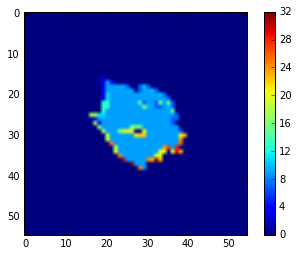

In [65]:
plt.imshow(eventData)
plt.colorbar()
plt.show()

In [26]:
eventData.dtype

dtype('float64')

Just a quick check to make sure the saved data matches the event data. You can delete.

In [58]:
savedRaster = gdal.Open('../out/waldo_raw_out.tif')
savedData = savedRaster.ReadAsArray()
print(np.count_nonzero(eventData))
print(np.count_nonzero(savedData))
print(np.count_nonzero(eventData-savedData))

335
335
0


In [59]:
savedData.max()

32.0

In [30]:
!gdalinfo -stats ../out/WUS_BurnDate_2014_out.tif

Driver: GTiff/GeoTIFF
Files: ../out/WUS_BurnDate_2014_out.tif
Size is 3720, 4320
Coordinate System is:
PROJCS["unnamed",
    GEOGCS["unnamed ellipse",
        DATUM["unknown",
            SPHEROID["unnamed",6370997,0]],
        PRIMEM["Greenwich",0],
        UNIT["degree",0.0174532925199433]],
    PROJECTION["Lambert_Azimuthal_Equal_Area"],
    PARAMETER["latitude_of_center",45],
    PARAMETER["longitude_of_center",-100],
    PARAMETER["false_easting",0],
    PARAMETER["false_northing",0],
    UNIT["metre",1,
        AUTHORITY["EPSG","9001"]]]
Origin = (-2032117.735286616021767,681214.871921156998724)
Pixel Size = (500.000000000000000,-500.000000000000000)
Metadata:
  AREA_OR_POINT=Area
Image Structure Metadata:
  INTERLEAVE=BAND
Corner Coordinates:
Upper Left  (-2032117.735,  681214.872) (127d57' 2.67"W, 47d52'11.96"N)
Lower Left  (-2032117.735,-1478785.128) (121d 2'16.90"W, 29d25' 6.64"N)
Upper Right ( -172117.735,  681214.872) (102d27'43.99"W, 51d 6'18.20"N)
Lower Right ( -172117.73